# TRAVAUX PRATIQUES VISION INFORMATIQUE


*Master 1 Sciences Cognitives*

Ce notebook Colab, réalisé dans le cadre de l’UE Vision Informatique, regroupe notre travail sur le traitement et l’analyse d’images : segmentation, détection de contours, calibration…

Auteurs : Maissane Sabbouri & Onur Arslan

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
from scipy.signal import convolve2d

## Partie 1 : Analyse d’image et mesure

## 1.1 Caractérisation des images

### 1. Calcul de l’histogramme

In [ ]:
image_path = "/content/key_16_17.png"

In [ ]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

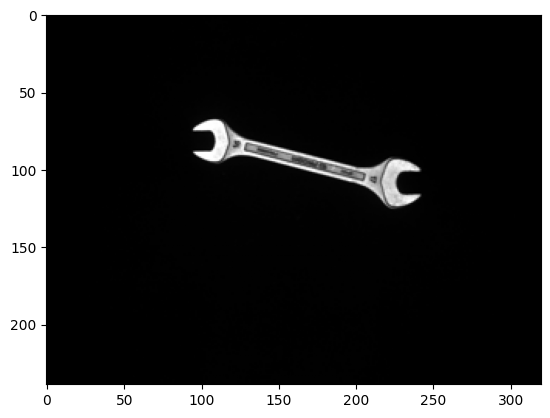

In [ ]:
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# Calculer l'histogramme
histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

# Trouver la valeur maximale de l'histogramme
max_value = np.max(histogram)

# Trouver l'index (niveau de gris) correspondant au maximum
max_index = np.argmax(histogram)

# Afficher les résultats
print("Valeur maximale :", max_value)
print("Niveau de gris correspondant :", max_index)

Valeur maximale : 40571.0
Niveau de gris correspondant : 0


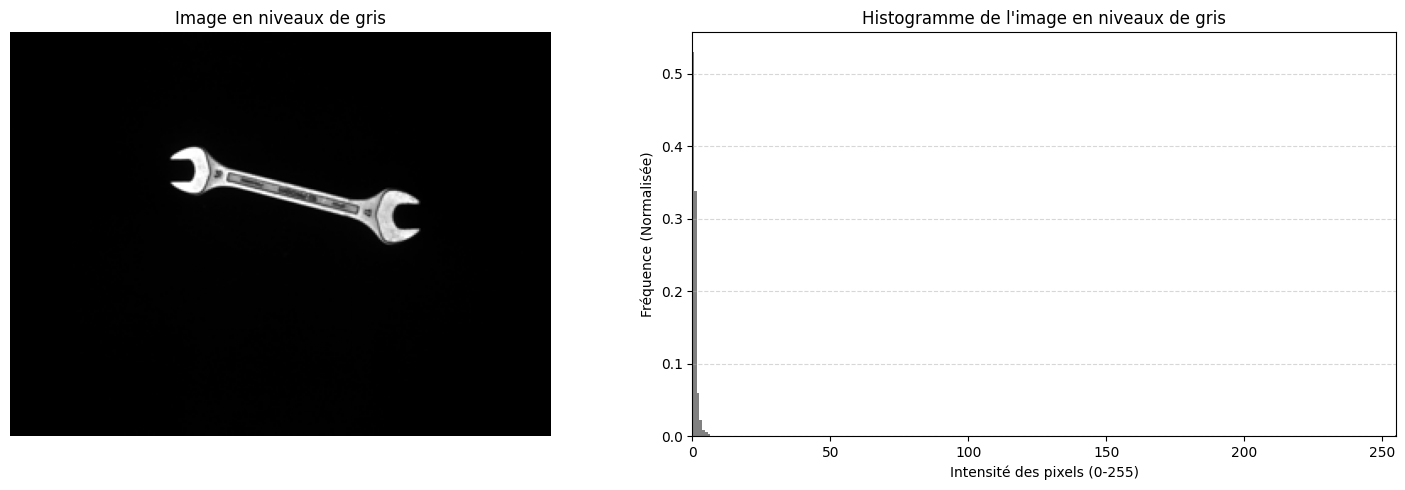

In [ ]:
def compute_histogram(image):
    # Calculer l'histogramme manuellement
    histogram = np.zeros(256, dtype=int)  # Initialiser un tableau pour 256 niveaux d'intensité

    # Compter l'occurrence des pixels
    for pixel_value in image.flatten():  # Aplatir l'image en un tableau 1D
        histogram[pixel_value] += 1
    return histogram

def normalize_histogram(histogram, image):
    # Normaliser l'histogramme en divisant chaque valeur par le nombre total de pixels
    total_pixels = image.shape[0] * image.shape[1]
    return histogram / total_pixels

def plot_histogram(image, histogram):
    # Créer une figure avec deux sous-graphiques : un pour l'image, un pour l'histogramme
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Afficher l'image en niveaux de gris à gauche
    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')  # Désactiver les axes de l'image
    ax[0].set_title("Image en niveaux de gris")

    # Tracer l'histogramme à droite
    ax[1].bar(range(256), histogram, color='gray', width=1.0)
    ax[1].set_xlabel("Intensité des pixels (0-255)")
    ax[1].set_ylabel("Fréquence (Normalisée)" if histogram.max() <= 1 else "Fréquence")
    ax[1].set_title("Histogramme de l'image en niveaux de gris")
    ax[1].set_xlim([0, 255])
    ax[1].grid(axis="y", linestyle="--", alpha=0.5)

    # Afficher les graphiques
    plt.tight_layout()
    plt.show()

histogram = compute_histogram(image)
histogram_normalized = normalize_histogram(histogram, image)
plot_histogram(image, histogram_normalized)

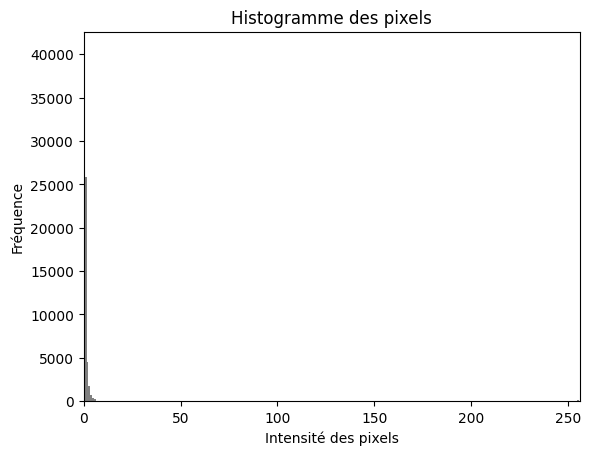

In [ ]:
histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

plt.figure()
plt.title("Histogramme des pixels")
plt.xlabel("Intensité des pixels")
plt.ylabel("Fréquence")

# Utiliser plt.bar pour créer un histogramme à barres
plt.bar(range(256), histogram.ravel(), color='gray', width=1.0)  # ravel() pour aplatir l'histogramme

plt.xlim([0, 256])
plt.show()

L’histogramme présente une forme unimodale avec un pic prononcé autour de 0, ce qui suggère que le noir est l’intensité dominante dans l’image et que l’image est globalement sombre. La majorité des pixels sont concentrés vers les valeurs sombres. Il y a toutefois quelques valeurs entre 200 et 250, ce qui représente certains pixels plus lumineux donc une image plutôt contrastée. De nombreuses zones plates sont observables entre environ 10 et 200, indiquant peu ou pas de pixels avec ces intensités.

Le pic autour de 0 représente probablement le fond noir de l’image tandis que certaines valeurs autour de 5 et 200 représentent les éléments au centre de la clé. Les valeurs plus claires autour de 250 représentent sûrement les bords de la clé.

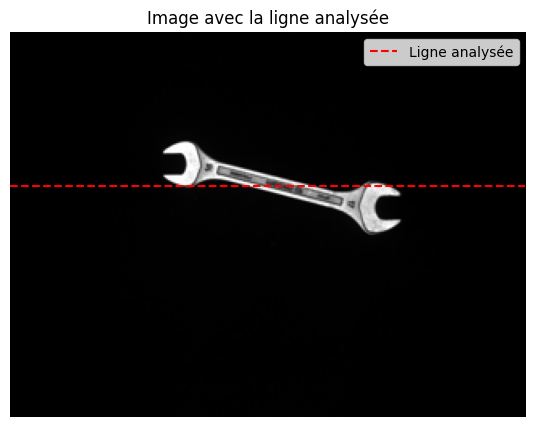

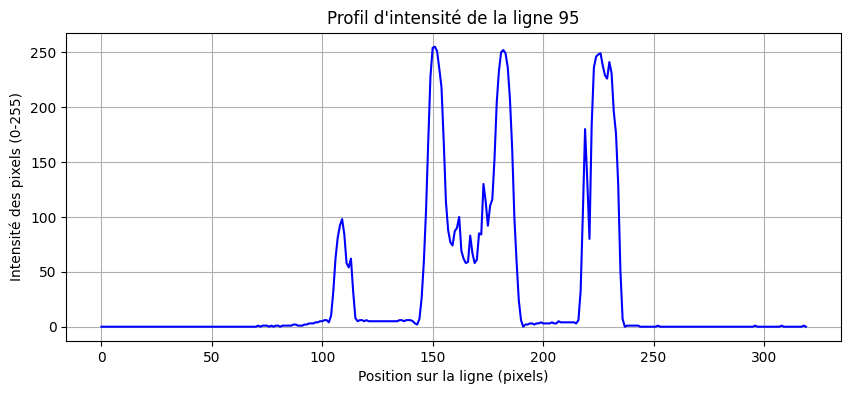

In [ ]:
if image is None:
    print(" Erreur : Impossible de charger l'image.")
else:
    # Sélection d'une ligne d'intérêt traversant le centre de la clé
    line_number = int(image.shape[0] * 0.4)  # Ligne située à 40% de la hauteur
    line_profile = image[line_number, :]

    # Affichage de l'image avec la ligne sélectionnée
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.axhline(y=line_number, color='red', linestyle='--', label="Ligne analysée")
    plt.axis("off")
    plt.title("Image avec la ligne analysée")
    plt.legend()
    plt.show()

    # Affichage du profil d'intensité
    plt.figure(figsize=(10, 4))
    plt.plot(line_profile, color='blue')
    plt.xlabel("Position sur la ligne (pixels)")
    plt.ylabel("Intensité des pixels (0-255)")
    plt.title(f"Profil d'intensité de la ligne {line_number}")
    plt.grid()
    plt.show()


Une ligne pertinente à analyser passerait idéalement par des zones avec un contraste marqué. Ici vers le centre de l'image puisque la clé est claire et située sur fond noir, si une ligne passe sure ces régions, elle présentera une forte variation d'intensité. L'histogramme nous montre également qu'il y a deux zones dominantes au niveau des pixels sombres et clairs. La ligne que nous avons choisi ici présente une forte transition entre les zones d'intensité et donne des informations sur le contraste entre ces dernières.

 ### 2. Comparaison des histogrammes

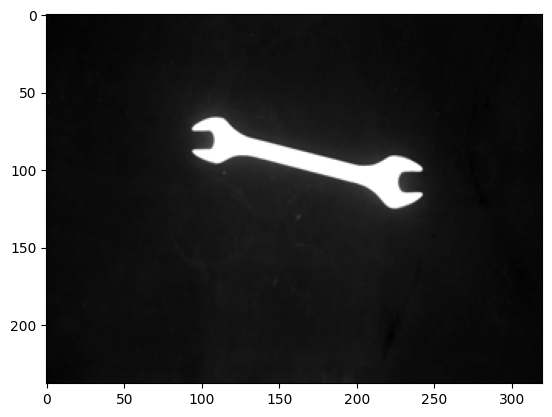

In [ ]:
image_path = "/content/Key_16_17_L.png"
image2 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image2, cmap='gray')
plt.show()

In [ ]:
# Calculer l'histogramme
histogram2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

# Trouver la valeur maximale de l'histogramme
max_value = np.max(histogram2)

# Trouver l'index (niveau de gris) correspondant au maximum
max_index = np.argmax(histogram2)

# Afficher les résultats
print("Valeur maximale :", max_value)
print("Niveau de gris correspondant :", max_index)

Valeur maximale : 6893.0
Niveau de gris correspondant : 57


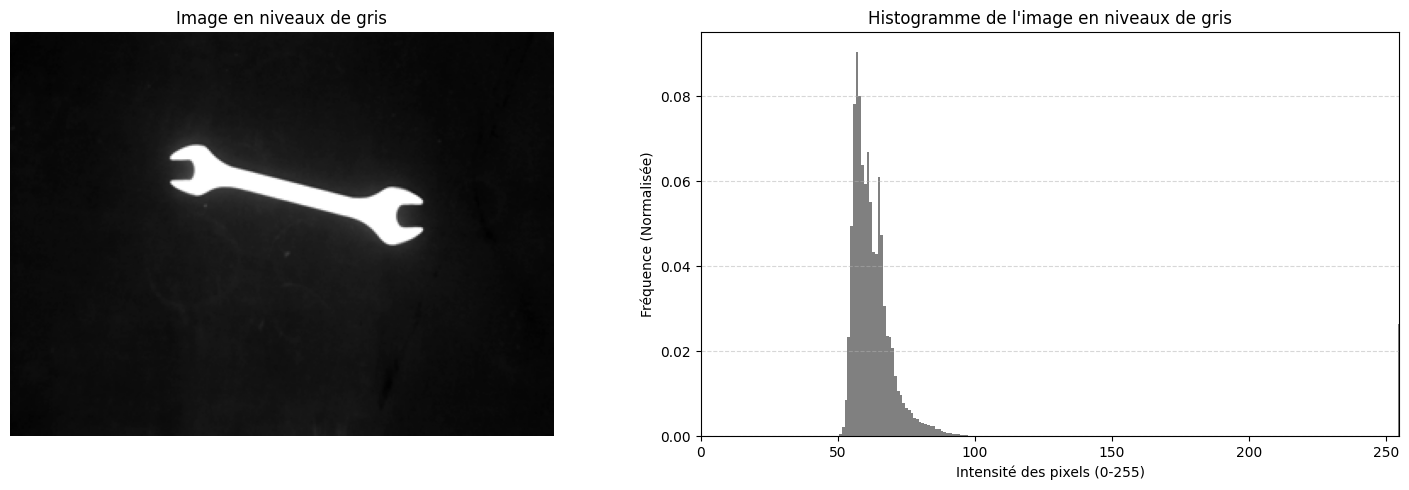

In [ ]:
def compute_histogram2(image2):
    # Calculer l'histogramme manuellement
    histogram2 = np.zeros(256, dtype=int)  # Initialiser un tableau pour les 256 niveaux d'intensité

    # Compter les occurrences des pixels
    for pixel_value in image2.flatten():  # Aplatir l'image en un tableau 1D
        histogram2[pixel_value] += 1
    return histogram2

def normalize_histogram(histogram2, image2):
    # Normaliser l'histogramme en divisant chaque valeur par le nombre total de pixels
    total_pixels = image2.shape[0] * image2.shape[1]
    return histogram2 / total_pixels

def plot_histogram(image2, histogram2):
    # Créer une figure avec deux sous-graphiques : un pour l'image et un pour l'histogramme
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Afficher l'image en niveaux de gris à gauche
    ax[0].imshow(image2, cmap='gray')
    ax[0].axis('off')  # Désactiver les axes pour l'image
    ax[0].set_title("Image en niveaux de gris")

    # Afficher l'histogramme à droite
    ax[1].bar(range(256), histogram2, color='gray', width=1.0)
    ax[1].set_xlabel("Intensité des pixels (0-255)")
    ax[1].set_ylabel("Fréquence (Normalisée)" if histogram2.max() <= 1 else "Fréquence")
    ax[1].set_title("Histogramme de l'image en niveaux de gris")
    ax[1].set_xlim([0, 255])
    ax[1].grid(axis="y", linestyle="--", alpha=0.5)

    # Afficher les graphiques
    plt.tight_layout()
    plt.show()

histogram2 = compute_histogram(image2)
histogram_normalized = normalize_histogram(histogram2, image2)
plot_histogram(image2, histogram_normalized)


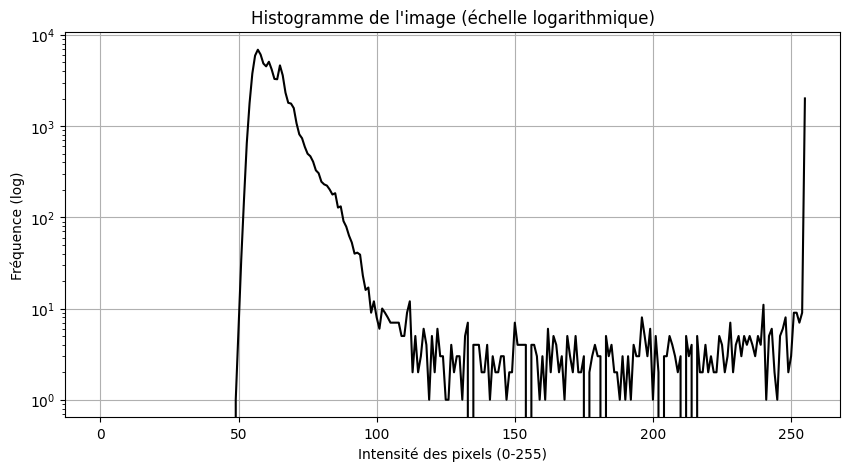

In [ ]:
# Voici un histogramme avec une meilleure échelle pour mieux apercevoir les pixels
plt.figure(figsize=(10, 5))
plt.plot(histogram2, color='black')
plt.yscale("log")  # Mettre une échelle logarithmique pour voir les petits détails
plt.xlabel("Intensité des pixels (0-255)")
plt.ylabel("Fréquence (log)")
plt.title("Histogramme de l'image (échelle logarithmique)")
plt.grid()
plt.show()

L’histogramme présente une forme unimodale avec un pic prononcé autour de 60, ce qui indique que le noir est l’intensité dominante et que l’image est majoritairement sombre. La majorité des pixels sont concentrés dans les faibles valeurs, ce qui correspond au fond de l’image. Cependant, un second pic vers 250 montre la présence de zones très lumineuses, indiquant un fort contraste entre le fond et l’objet central.

Le pic autour de 60 du premier graphe représente probablement le fond sombre de l’image, tandis que les valeurs élevées proches de 250 correspondent aux zones les plus claires de la clé. Entre environ 10 et 200, l’histogramme est presque plat, montrant que peu de pixels ont des intensités intermédiaires. Cela confirme une image avec un contraste marqué, où la clé ressort nettement sur le fond.

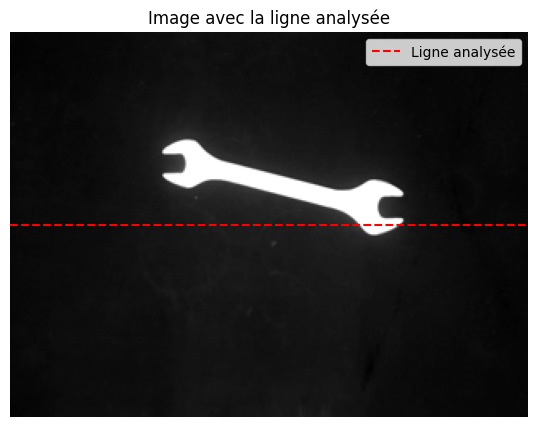

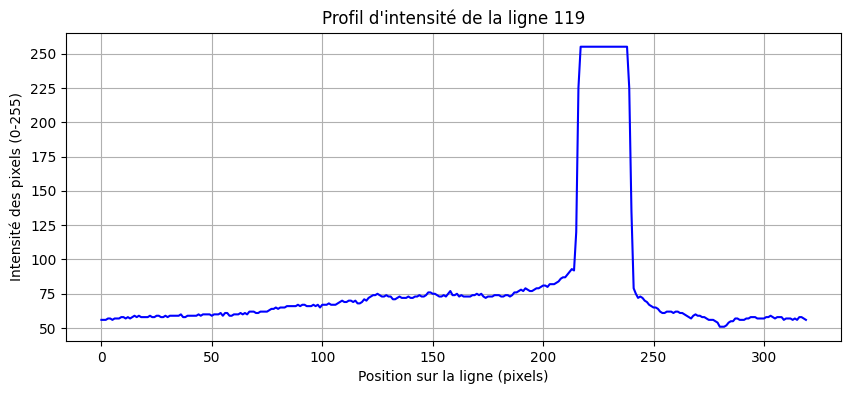

In [ ]:
if image2 is None:
    print("Erreur : Impossible de charger l'image.")
else:
    # Sélection d'une ligne d'intérêt (ligne médiane)
    line_number = image2.shape[0] // 2  # Ligne médiane
    line_profile = image2[line_number, :]

    # Affichage de l'image avec la ligne sélectionnée
    plt.figure(figsize=(10, 5))
    plt.imshow(image2, cmap='gray')
    plt.axhline(y=line_number, color='red', linestyle='--', label="Ligne analysée")
    plt.axis("off")
    plt.title("Image avec la ligne analysée")
    plt.legend()
    plt.show()

    # Affichage du profil d'intensité
    plt.figure(figsize=(10, 4))
    plt.plot(line_profile, color='blue')
    plt.xlabel("Position sur la ligne (pixels)")
    plt.ylabel("Intensité des pixels (0-255)")
    plt.title(f"Profil d'intensité de la ligne {line_number}")
    plt.grid()
    plt.show()


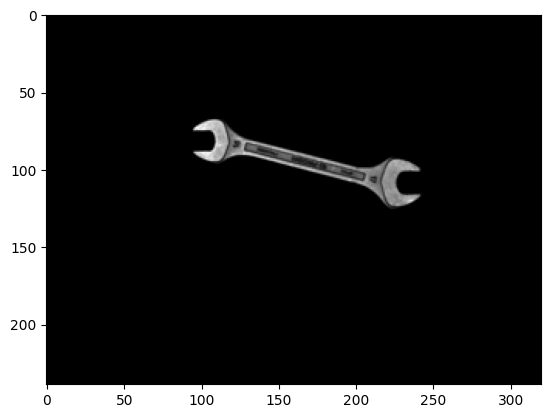

In [ ]:
image_path = "/content/Key_16_17_D.png"
image3 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image3, cmap='gray')
plt.show()

In [ ]:
# Calculer l'histogramme
histogram3 = cv2.calcHist([image3], [0], None, [256], [0, 256])

# Trouver la valeur maximale de l'histogramme
max_value = np.max(histogram3)

# Trouver l'index (niveau de gris) correspondant au maximum
max_index = np.argmax(histogram3)

# Afficher les résultats
print("Valeur maximale :", max_value)
print("Niveau de gris correspondant :", max_index)

Valeur maximale : 74196.0
Niveau de gris correspondant : 0


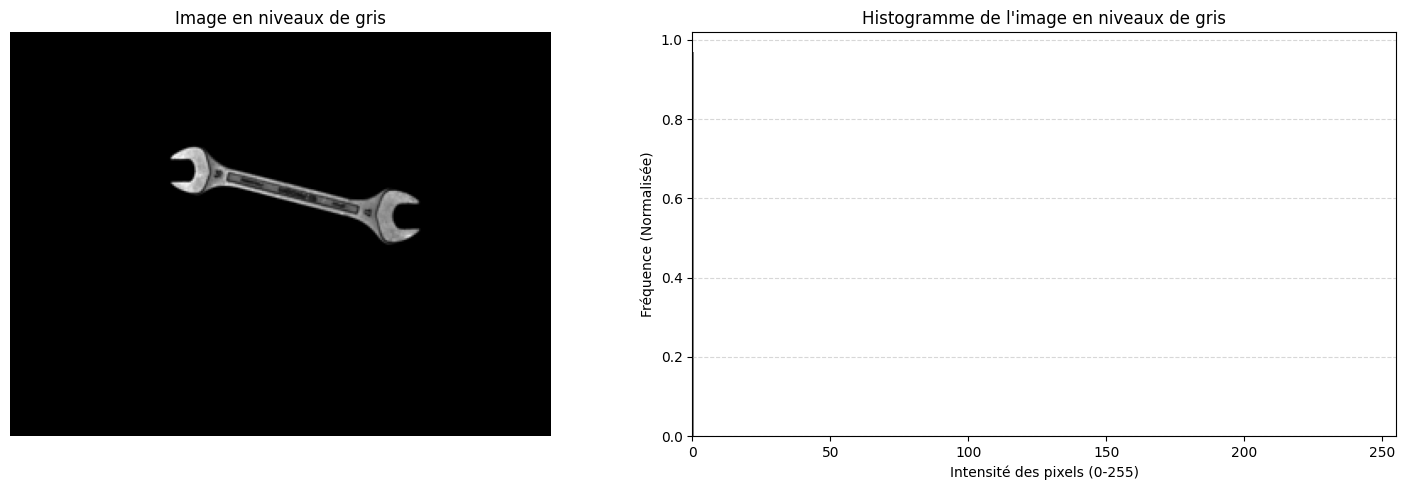

In [ ]:
def compute_histogram(image3):
    # Calculer l'histogramme manuellement
    histogram3 = np.zeros(256, dtype=int)  # Initialiser un tableau pour les 256 valeurs d'intensité

    # Compter les occurrences des pixels
    for pixel_value in image3.flatten():  # Aplatir l'image en un tableau 1D
        histogram3[pixel_value] += 1
    return histogram3

def normalize_histogram(histogram3, image3):
    # Normaliser en divisant chaque valeur du bin par le nombre total de pixels
    total_pixels = image3.shape[0] * image3.shape[1]
    return histogram3 / total_pixels

def plot_histogram(image3, histogram3):
    # Créer une figure avec deux sous-graphiques : un pour l'image3 et un pour l'histogramme
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Afficher l'image à gauche
    ax[0].imshow(image3, cmap='gray')
    ax[0].axis('off')  # Désactiver l'axe pour l'image
    ax[0].set_title("Image en niveaux de gris")

    # Afficher l'histogramme à droite
    ax[1].bar(range(256), histogram3, color='gray', width=1.0)
    ax[1].set_xlabel("Intensité des pixels (0-255)")
    ax[1].set_ylabel("Fréquence (Normalisée)" if histogram3.max() <= 1 else "Fréquence")
    ax[1].set_title("Histogramme de l'image en niveaux de gris")
    ax[1].set_xlim([0, 255])
    ax[1].grid(axis="y", linestyle="--", alpha=0.5)

    # Afficher les graphiques
    plt.tight_layout()
    plt.show()

histogram3 = compute_histogram(image3)
histogram_normalized = normalize_histogram(histogram3, image3)
plot_histogram(image3, histogram_normalized)

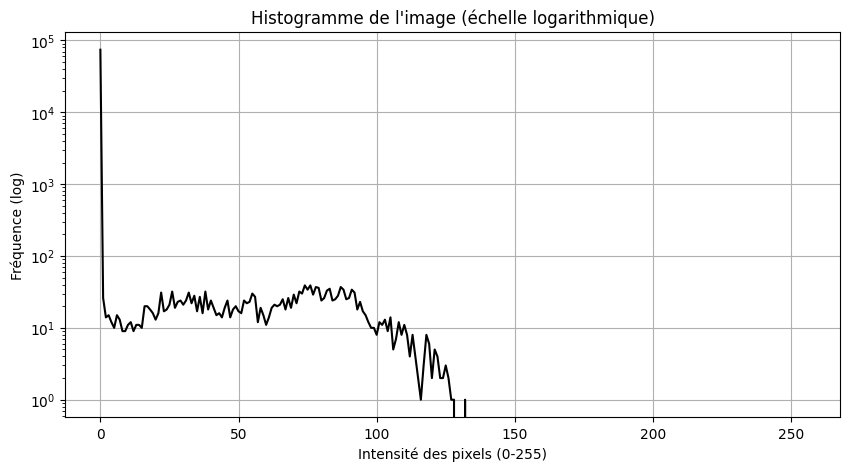

In [ ]:
# Voici un histogramme avec une meilleure échelle pour mieux apercevoir les pixels
plt.figure(figsize=(10, 5))
plt.plot(histogram3, color='black')
plt.yscale("log")  # Mettre une échelle logarithmique pour voir les petits détails
plt.xlabel("Intensité des pixels (0-255)")
plt.ylabel("Fréquence (log)")
plt.title("Histogramme de l'image (échelle logarithmique)")
plt.grid()
plt.show()

L’histogramme présente une forme unimodale avec un pic prononcé autour de 0, ce qui indique que le noir est l’intensité dominante et que l’image est globalement sombre. La majorité des pixels sont concentrés dans les faibles valeurs, ce qui correspond au fond noir entourant la clé.

On observe également des valeurs réparties entre 50 et 150, correspondant aux détails de la clé, qui apparaissent dans des tons intermédiaires de gris. Cependant, contrairement à une image très contrastée, il n'y a pas de pic marqué vers 250, ce qui signifie qu'il y a peu de zones très lumineuses.

Le pic autour de 0 représente le fond noir de l’image, tandis que les valeurs situées entre 50 et 150 traduisent les détails internes de la clé métallique. L’absence de valeurs proches de 250 indique que la clé ne contient pas de zones fortement réfléchissantes. L’image est donc moins contrastée que celles où la clé apparaît en blanc intense sur un fond noir.

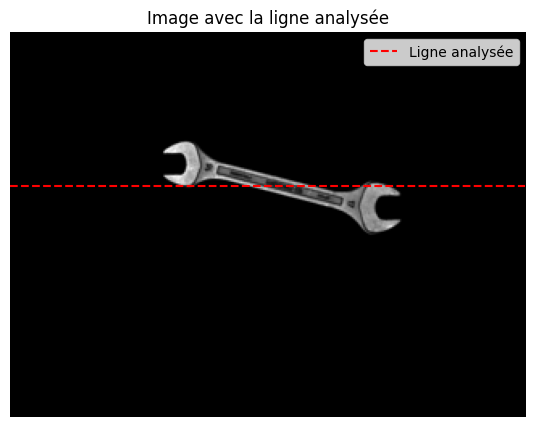

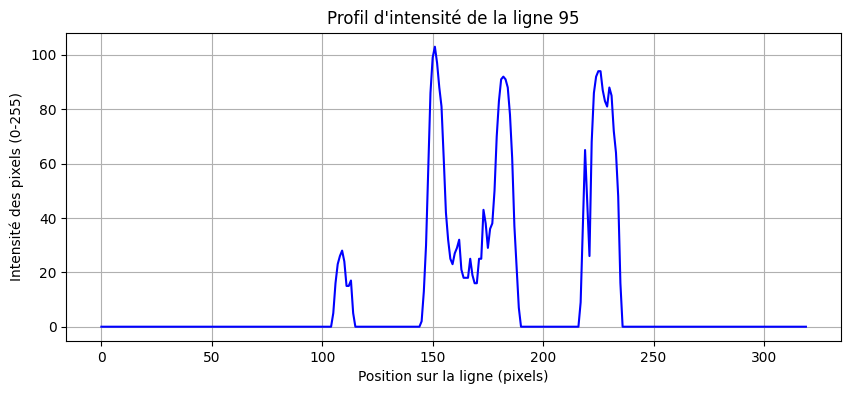

In [ ]:
if image3 is None:
    print("Erreur : Impossible de charger l'image.")
else:
    # Sélection d'une ligne d'intérêt traversant le centre de la clé
    line_number = int(image3.shape[0] * 0.4)  # Ligne située à 40% de la hauteur
    line_profile = image3[line_number, :]

    # Affichage de l'image avec la ligne sélectionnée
    plt.figure(figsize=(10, 5))
    plt.imshow(image3, cmap='gray')
    plt.axhline(y=line_number, color='red', linestyle='--', label="Ligne analysée")
    plt.axis("off")
    plt.title("Image avec la ligne analysée")
    plt.legend()
    plt.show()

    # Affichage du profil d'intensité
    plt.figure(figsize=(10, 4))
    plt.plot(line_profile, color='blue')
    plt.xlabel("Position sur la ligne (pixels)")
    plt.ylabel("Intensité des pixels (0-255)")
    plt.title(f"Profil d'intensité de la ligne {line_number}")
    plt.grid()
    plt.show()


Nous avons choisi une ligne assez haute, qui traverse le centre de la clé, où l’on observe une transition entre le fond noir et la structure métallique pour pouvoir observer les variations d'intensité sur l'image.

Si on compare les histogrammes, on peut voir que dans certaines images, la clé apparaît plus blanche avec un fond légèrement moins sombre. L’histogramme se décale légèrement vers la droite car il y a plus de pixels clairs. Cela indique une augmentation globale de la luminosité dans l’image. Lorsque la clé est moins contrastée et plus grise, les niveaux de gris sont plus répartis entre 50 et 150. L’histogramme reste concentré à gauche, mais avec une meilleure répartition des intensités.Cela signifie que l’image a moins de zones saturées. Si l’image a un contraste fort, l’histogramme montre deux pics bien distincts (un autour de 0 pour le fond et un autour de 250 pour la clé). Si le contraste diminue, l’histogramme devient plus étalé avec moins de séparation entre le fond et la clé.

Les différences observées dans les histogrammes peuvent être dues à plusieurs changements dans les conditions d’acquisition. Une modification de l’éclairage peut avoir un impact significatif. Une source lumineuse plus intense ou orientée différemment peut rendre la clé plus brillante et augmenter la proportion de pixels clairs. À l’inverse, une lumière plus diffuse réduit le contraste, rendant les zones sombres et claires moins distinctes.

Les réglages de la caméra jouent également un rôle important. Une augmentation du temps d’exposition ou de la sensibilité peut rendre l’image plus lumineuse, ce qui se traduit par un déplacement de l’histogramme vers les hautes intensités. La balance des blancs et d’autres ajustements automatiques du capteur peuvent aussi modifier la répartition des niveaux de gris, influençant ainsi l’histogramme.

Enfin, la position et l’orientation de la clé par rapport à la caméra peuvent affecter la répartition des intensités. Un léger changement d’angle peut modifier la manière dont la lumière est réfléchie, créant des zones plus claires ou plus sombres. De plus, une variation de la distance entre l’objet et la caméra peut influencer la capture des détails, entraînant une répartition différente des pixels dans l’image.

# 3. Traitement de seuillage

Pour segmenter la clé du fond, nous avons utilisé un seuillage binaire manuel, qui consiste à fixer un seuil d’intensité et à convertir chaque pixel en noir ou blanc en fonction de cette valeur. Il permet un contrôle précis du seuil et offre une segmentation efficace lorsque la différence de contraste entre l’objet et le fond est marquée. Tous les pixels dont l’intensité est supérieure au seuil défini sont convertis en blanc, tandis que ceux en dessous du seuil deviennent noirs.
Cette méthode permet d’éviter les erreurs d’ajustement automatique dans des cas où le contraste pourrait ne pas être bien défini. De plus, elle est plus robuste que le seuillage adaptatif car elle n’est pas affectée par les variations locales de luminosité, qui peuvent parfois générer du bruit ou des artefacts sur les bords de la clé. En ajustant manuellement le seuil, nous nous assurons d’une séparation nette et stable entre la clé et le fond, facilitant ainsi son analyse ultérieure.

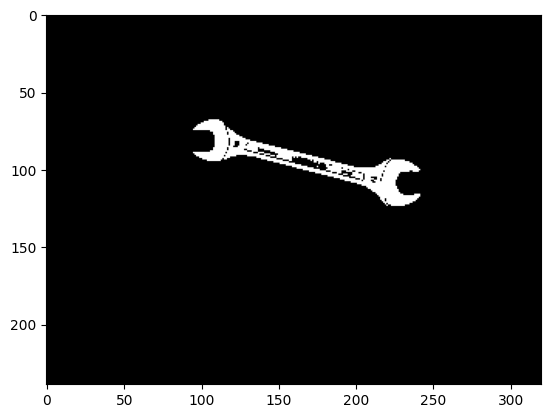

In [ ]:
def seuillage_mask(image, seuil):
    # Créer une image binaire où les pixels supérieurs au seuil sont 255 (blanc)
    # et les autres pixels sont 0 (noir)
    image_binaire = np.where(image > seuil, 255, 0)
    return image_binaire.astype(np.uint8)

# Appel de la fonction 'seuillage_mask'
image_binaire = seuillage_mask(image, 100)
plt.imshow(image_binaire, cmap="gray")
plt.show()

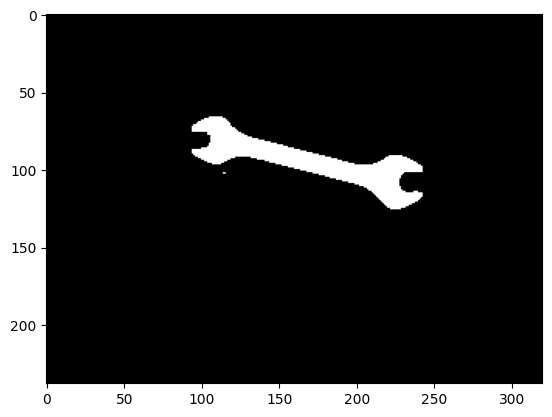

In [ ]:
def seuillage_mask(image2, seuil):
    # Créer une image binaire où les pixels supérieurs au seuil sont 255 (blanc)
    # et les autres pixels sont 0 (noir)
    image_binaire = np.where(image2 > seuil, 255, 0)
    return image_binaire.astype(np.uint8)

# Appel de la fonction 'seuillage_mask'
image_binary = seuillage_mask(image2, 100)
plt.imshow(image_binary, cmap="gray")
plt.show()

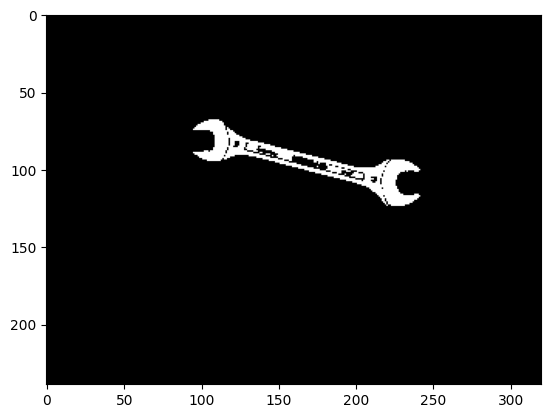

In [ ]:
def seuillage_mask(image3, seuil):
    # Créer une image binaire où les pixels supérieurs au seuil sont 255 (blanc)
    # et les autres pixels sont 0 (noir)
    image_binaire = np.where(image3 > seuil, 255, 0)
    return image_binaire.astype(np.uint8)

# Appel de la fonction 'seuillage_mask'
image_binary = seuillage_mask(image3, 35)
plt.imshow(image_binary, cmap="gray")
plt.show()

# 4. Comparaison de seuillage

Lorsqu’un pic bien distinct apparaît pour le fond et un autre pour l’objet, il est possible de fixer un seuil manuel entre ces deux valeurs pour un seuillage binaire efficace. Si l’histogramme présente une transition floue entre les niveaux de gris, un seuillage adaptatif peut être plus adapté pour ajuster localement le seuil en fonction des variations de l’image. Enfin, si la séparation entre l’objet et le fond est ambiguë, des méthodes comme le seuillage d’Otsu peuvent être utilisées pour calculer automatiquement un seuil optimal basé sur la distribution des intensités.

Une approche efficace consiste à analyser l’histogramme et à repérer le premier pic significatif pour déterminer un seuil approximatif. Ce seuil peut ensuite être appliqué dans un seuillage binaire simple pour transformer l’image en noir et blanc en fonction des intensités détectées.

Ainsi, l’histogramme joue un rôle clé dans le choix des paramètres de seuillage en permettant une segmentation plus précise et mieux adaptée aux conditions de l’image.

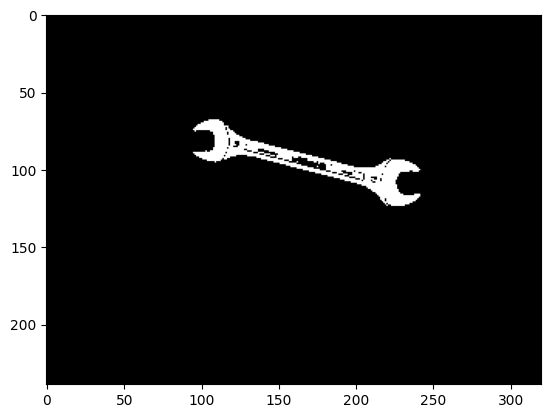

In [ ]:
def otsu_threshold(image):
    # Calcul de l'histogramme de l'image
    hist = compute_histogram(image)

    # Normalisation de l'histogramme pour obtenir les probabilités de chaque pixel
    total_pixels = image.size
    probas = hist / total_pixels  # Probabilité d'apparition pour chaque pixel

    # Calcul de la moyenne globale de l'image
    global_mean = np.mean(image)

    # Initialisation des variables pour le calcul du seuil optimal
    best_threshold = 0
    max_between_class_variance = 0

    # Variables pour stocker les informations sur les classes
    w0 = 0  # Poids de la première classe (pixels <= T)
    w1 = 0  # Poids de la deuxième classe (pixels > T)
    mean0 = 0  # Moyenne de la première classe
    mean1 = 0  # Moyenne de la deuxième classe

    # Parcourir tous les seuils possibles (de 0 à 255)
    for t in range(256):
        w0 += probas[t]  # Mettre à jour le poids de la première classe
        if w0 == 0 or w0 == 1:  # Éviter la division par zéro
            continue
        w1 = 1 - w0  # Poids de la deuxième classe

        mean0 += t * probas[t]  # Mettre à jour la moyenne de la première classe
        mean1 = (global_mean - mean0) / w1  # Calculer la moyenne de la deuxième classe

        # Calculer la variance inter-classes
        between_class_variance = w0 * w1 * (mean0 / w0 - mean1) ** 2

        # Vérifier si la variance est maximisée
        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            best_threshold = t

    # Appliquer le seuil pour créer une image binaire
    binary_image = np.where(image > best_threshold, 255, 0).astype(np.uint8)

    return best_threshold, binary_image

# Appliquer le seuil d'Otsu pour obtenir l'image binaire
best_threshold, image_otsu = otsu_threshold(image)
plt.imshow(image_otsu, cmap="gray")
plt.show()

In [ ]:
best_threshold, image_otsu = otsu_threshold(image)
print(f"Le seuil d'Otsu optimal est : {best_threshold}")

Le seuil d'Otsu optimal est : 97


En faisant la comparaison entre le seuil manuel et le seuil automatique, on peut voir que dans les deux cas, segmentations sont très similaires. Le contour de la clé est bien conservé. Toutefois, le seuillage d'Otsu introduit quelques variations internes à la clé.
L'écart entre les seuils (100 vs 97) est faible, ce qui montre que l'estimation automatique d'Otsu fonctionne bien. Le seuillage manuel était donc bien ajusté.


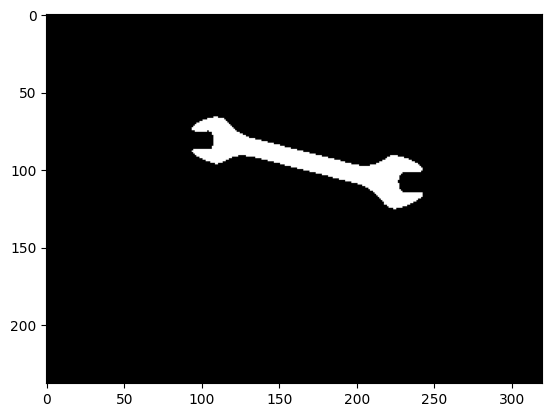

In [ ]:
def otsu_threshold(image2):
    # Calcul de l'histogramme de l'image2
    hist = compute_histogram(image2)

    # Normalisation de l'histogramme pour obtenir les probabilités de chaque pixel
    total_pixels = image2.size
    probas = hist / total_pixels  # Probabilité d'apparition pour chaque pixel

    # Calcul de la moyenne globale de l'image2
    global_mean = np.mean(image2)

    # Initialisation des variables pour le calcul du seuil optimal
    best_threshold2 = 0
    max_between_class_variance = 0

    # Variables pour stocker les informations sur les classes
    w0 = 0  # Poids de la première classe (pixels <= T)
    w1 = 0  # Poids de la deuxième classe (pixels > T)
    mean0 = 0  # Moyenne de la première classe
    mean1 = 0  # Moyenne de la deuxième classe

    # Parcourir tous les seuils possibles (de 0 à 255)
    for t in range(256):
        w0 += probas[t]  # Mettre à jour le poids de la première classe
        if w0 == 0 or w0 == 1:  # Éviter la division par zéro
            continue
        w1 = 1 - w0  # Poids de la deuxième classe

        mean0 += t * probas[t]  # Mettre à jour la moyenne de la première classe
        mean1 = (global_mean - mean0) / w1  # Calculer la moyenne de la deuxième classe

        # Calculer la variance inter-classes
        between_class_variance = w0 * w1 * (mean0 / w0 - mean1) ** 2

        # Vérifier si la variance est maximisée
        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            best_threshold2 = t

    # Appliquer le seuil pour créer une image binaire
    binary_image2 = np.where(image2 > best_threshold2, 255, 0).astype(np.uint8)

    return best_threshold2, binary_image2

# Appliquer le seuil d'Otsu pour obtenir l'image binaire
best_threshold2, image2_otsu = otsu_threshold(image2)
plt.imshow(image2_otsu, cmap="gray")
plt.show()

In [ ]:
best_threshold2, image2_otsu = otsu_threshold(image2)
print(f"Le seuil d'Otsu optimal est : {best_threshold2}")

Le seuil d'Otsu optimal est : 154


Otsu choisit un seuil plus élevé (154) par rapport au seuil manuel (100). Cela entraîne une perte d’information sur certaines zones de la clé. Le seuillage manuel conserve mieux la forme complète de la clé.
Un seuil trop élevé peut entraîner une sous-segmentation, c'est-à-dire que certaines parties de la clé disparaissent. Le seuillage manuel à 100 semble plus adapté pour cette image.

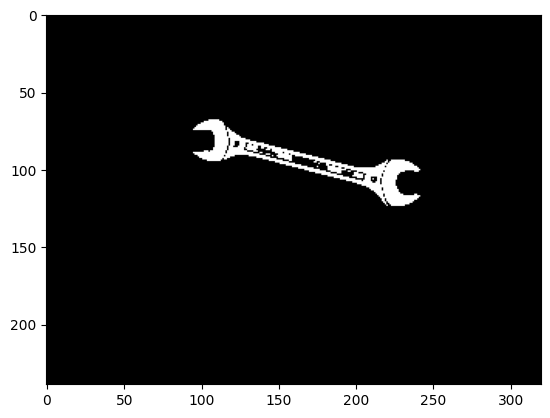

In [ ]:
def otsu_threshold(image3):
    # Calcul de l'histogramme de l'image3
    hist = compute_histogram(image3)

    # Normalisation de l'histogramme pour obtenir les probabilités de chaque pixel
    total_pixels = image3.size
    probas = hist / total_pixels  # Probabilité d'apparition pour chaque pixel

    # Calcul de la moyenne globale de l'image3
    global_mean = np.mean(image3)

    # Initialisation des variables pour le calcul du seuil optimal
    best_threshold3 = 0
    max_between_class_variance = 0

    # Variables pour stocker les informations sur les classes
    w0 = 0  # Poids de la première classe (pixels <= T)
    w1 = 0  # Poids de la deuxième classe (pixels > T)
    mean0 = 0  # Moyenne de la première classe
    mean1 = 0  # Moyenne de la deuxième classe

    # Parcourir tous les seuils possibles (de 0 à 255)
    for t in range(256):
        w0 += probas[t]  # Mettre à jour le poids de la première classe
        if w0 == 0 or w0 == 1:  # Éviter la division par zéro
            continue
        w1 = 1 - w0  # Poids de la deuxième classe

        mean0 += t * probas[t]  # Mettre à jour la moyenne de la première classe
        mean1 = (global_mean - mean0) / w1  # Calculer la moyenne de la deuxième classe

        # Calculer la variance inter-classes
        between_class_variance = w0 * w1 * (mean0 / w0 - mean1) ** 2

        # Vérifier si la variance est maximisée
        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            best_threshold3 = t

    # Appliquer le seuil pour créer une image binaire
    binary_image3 = np.where(image3 > best_threshold3, 255, 0).astype(np.uint8)

    return best_threshold3, binary_image3

# Appliquer le seuil d'Otsu pour obtenir l'image binaire
best_threshold3, image3_otsu = otsu_threshold(image3)
plt.imshow(image3_otsu, cmap="gray")
plt.show()


In [ ]:
best_threshold3, image3_otsu = otsu_threshold(image3)
print(f"Le seuil d'Otsu optimal est : {best_threshold3}")

Le seuil d'Otsu optimal est : 37


Les deux segmentations sont très proches, indiquant que l’image avait une bonne séparation entre l’objet et le fond. Otsu trouve un seuil légèrement supérieur (37), mais la différence est minime.
Otsu est efficace ici car l’image présente une séparation claire des niveaux de gris. Le seuillage manuel aurait pu être ajusté de quelques valeurs seulement, sans impact majeur.

## 1.2 Pré-traitement avant contrôle dimensionnel

### 1. Délimitation de la zone d’intêret (ROI)

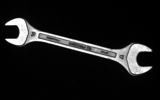

In [ ]:
# Définir les coordonnées de la ROI (x, y, largeur, hauteur)
x, y, w, h = 90, 50, 160, 100  # Ajustez selon la position de la clé

# Extraire la ROI
roi = image[y:y+h, x:x+w]

# Afficher la ROI en utilisant cv2_imshow
cv2_imshow(roi)  # Afficher directement sans assigner à une variable

La région d’intérêt a été définie en délimitant une zone rectangulaire autour de la clé, en utilisant les coordonnées (x, y, w, h). L’objectif est de concentrer l’analyse sur la zone contenant la clé et d’exclure les zones inutiles du fond, ce qui réduit le bruit et améliore l’efficacité du traitement.
Comme la clé est toujours positionnée approximativement au même endroit, il est pertinent de définir une ROI fixe qui englobe l’objet tout en excluant les bords de l’image. En limitant l’analyse à la zone où se trouve la clé, on évite de traiter les pixels du fond noir, qui ne sont pas utiles au contrôle des dimensions. En réduisant la taille de l’image à analyser, on accélère les traitements et on évite les erreurs liées à des artefacts présents en dehors de la zone utile.

# 2. Choix d’une méthode de seuillage automatique

Pour segmenter automatiquement la clé du fond, nous utilisons le seuillage d’Otsu, qui permet de déterminer dynamiquement le seuil optimal en fonction de l’histogramme de l’image. Cette méthode est bien adaptée aux images Key*, car elle s’ajuste automatiquement aux variations de luminosité et de contraste.
Les images Key* présentent des variations dans les conditions d’acquisition, notamment les changements d’éclairage. Si la source lumineuse varie, la clé peut apparaître plus claire ou plus sombre, rendant un seuil fixe inefficace.
Il y a des différences de contraste. Si la clé est plus réfléchissante dans certaines images et moins contrastée dans d’autres, un seuil manuel pourrait ne pas fonctionner uniformément. De plus, les images présentent des reflets ou des ombres. Otsu analyse l’histogramme global et adapte dynamiquement le seuil pour séparer la clé du fond, même si les intensités de pixels varient légèrement d’une image à l’autre.

Lors du test de notre méthode de seuillage sur différentes images, nous afficherons le seuillage d’Otsu à gauche et le seuillage adaptatif à droite afin de comparer les deux méthodes. Otsu, plus global, applique un seuil unique à toute l’image, tandis que le seuillage adaptatif ajuste localement le seuil en fonction des variations de contraste.

Ainsi, la méthode d'Otsu permet d’avoir une vue d’ensemble de la segmentation avec une séparation nette entre la clé et le fond. Ensuite, le seuillage adaptatif met en évidence des détails plus fins mais peut introduire du bruit et des contours trop marqués.

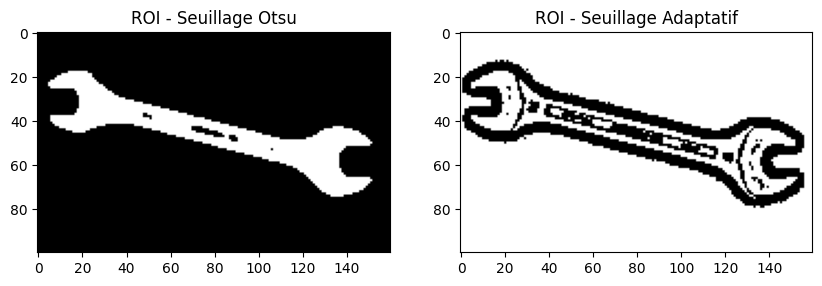

In [ ]:
def otsu_threshold(image):
    """Applique le seuillage d'Otsu sur une image et retourne l'image binaire."""
    if image is None:
        print("Error: Image not loaded. Check file path and permissions.")
        return None

    blur = cv2.GaussianBlur(image, (5, 5), 0)  # Réduction du bruit
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def adaptive_threshold(image):
    """Applique le seuillage adaptatif sur une image pour gérer les variations de lumière."""
    if image is None:
        print("Error: Image not loaded. Check file path and permissions.")
        return None

    binary_adaptive = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    return binary_adaptive

# Définition de la région d’intérêt (ROI) - Ajuster selon l’image
x, y, w, h = 90, 50, 160, 100
roi = image[y:y+h, x:x+w]  # Extraction de la ROI

# Appliquer les méthodes de seuillage sur la ROI
otsu_segmented = otsu_threshold(roi)
adaptive_segmented = adaptive_threshold(roi)

# Vérifier si les images ont bien été traitées avant affichage
if otsu_segmented is not None and adaptive_segmented is not None:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(otsu_segmented, cmap="gray")
    plt.title("ROI - Seuillage Otsu")

    plt.subplot(1, 2, 2)
    plt.imshow(adaptive_segmented, cmap="gray")
    plt.title("ROI - Seuillage Adaptatif")

    plt.show()

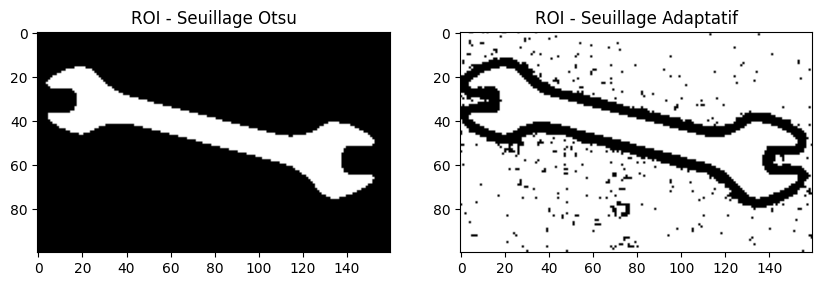

In [ ]:
def otsu_threshold(image2):
    """Applique le seuillage d'Otsu sur une image et retourne l'image binaire."""
    if image2 is None:
        print("Error: Image not loaded. Check file path and permissions.")
        return None

    blur = cv2.GaussianBlur(image2, (5, 5), 0)  # Réduction du bruit
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def adaptive_threshold(image2):
    """Applique le seuillage adaptatif sur une image pour gérer les variations de lumière."""
    if image2 is None:
        print("Error: Image not loaded. Check file path and permissions.")
        return None


    binary_adaptive = cv2.adaptiveThreshold(image2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    return binary_adaptive

# Définition de la région d’intérêt (ROI)
x, y, w, h = 90, 50, 160, 100
roi = image2[y:y+h, x:x+w]  # Extraction de la ROI

# Appliquer les méthodes de seuillage sur la ROI
otsu_segmented = otsu_threshold(roi)
adaptive_segmented = adaptive_threshold(roi)

# Vérifier si les images ont bien été traitées avant affichage
if otsu_segmented is not None and adaptive_segmented is not None:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(otsu_segmented, cmap="gray")
    plt.title("ROI - Seuillage Otsu")

    plt.subplot(1, 2, 2)
    plt.imshow(adaptive_segmented, cmap="gray")
    plt.title("ROI - Seuillage Adaptatif")

    plt.show()

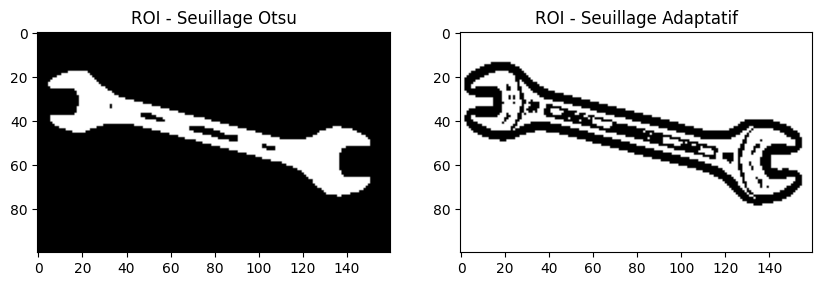

In [ ]:
def otsu_threshold(image3):
    """Applique le seuillage d'Otsu sur une image et retourne l'image binaire."""
    if image3 is None:
        print("Error: Image not loaded. Check file path and permissions.")
        return None

    blur = cv2.GaussianBlur(image3, (5, 5), 0)  # Réduction du bruit
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def adaptive_threshold(image3):
    """Applique le seuillage adaptatif sur une image pour gérer les variations de lumière."""
    if image3 is None:
        print("Error: Image not loaded. Check file path and permissions.")
        return None


    binary_adaptive = cv2.adaptiveThreshold(image3, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    return binary_adaptive

# Définition de la région d’intérêt (ROI)
x, y, w, h = 90, 50, 160, 100
roi = image3[y:y+h, x:x+w]  # Extraction de la ROI

# Appliquer les méthodes de seuillage sur la ROI
otsu_segmented = otsu_threshold(roi)
adaptive_segmented = adaptive_threshold(roi)

# Vérifier si les images ont bien été traitées avant affichage
if otsu_segmented is not None and adaptive_segmented is not None:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(otsu_segmented, cmap="gray")
    plt.title("ROI - Seuillage Otsu")

    plt.subplot(1, 2, 2)
    plt.imshow(adaptive_segmented, cmap="gray")
    plt.title("ROI - Seuillage Adaptatif")

    plt.show()

Les résultats montrent des différences significatives entre les deux méthodes de seuillage sur la ROI. Le seuillage d’Otsu permet d'obtenir une segmentation nette de la clé, ce qui permet une bonne isolation. Toutefois, dans certaines images, des pertes d’information sont visibles, notamment des trous noirs sur certaines parties de la clé. Cela peut être dû à des variations locales de contraste qui perturbent la détection uniforme.

Le seuillage adaptatif met mieux en évidence les détails internes de la clé, notamment les gravures et les bords. Cependant, cette méthode est fortement affectée par le bruit et crée des éléments "indésirables" autour de la clé. De plus, les contours sont parfois trop accentués, ce qui pourrait rendre l’interprétation des résultats plus complexe.

En conclusion, le seuillage adaptatif est trop sensible aux variations de l’arrière-plan, ce qui entraîne l’apparition de nombreux points parasites. Par ailleurs, certaines zones internes de la clé sont mal détectées, ce qui peut poser problème pour l’analyse de sa structure. Lorsque l’éclairage varie, Otsu peut perdre en précision et le seuillage adaptatif devient encore plus bruité.

Pour améliorer la robustesse des méthodes de seuillage, plusieurs ajustements peuvent être réalisés. Tout d’abord, un filtrage morphologique après seuillage permettrait d’éliminer les petits bruits générés par le seuillage adaptatif grâce à une opération d’ouverture morphologique, tandis qu’une fermeture morphologique aiderait à combler les trous dans la segmentation obtenue avec Otsu. Ensuite, augmenter le flou gaussien avant Otsu en modifiant le noyau permettrait de lisser davantage les variations locales et d’éviter les artefacts indésirables. De plus, modifier la taille de la fenêtre du seuillage adaptatif en l’agrandissant améliorerait son adaptation locale et réduirait les contours excessivement marqués. Enfin, appliquer une égalisation d’histogramme avant seuillage  permettrait d’uniformiser les niveaux de gris et de rendre les seuils plus cohérents, améliorant ainsi la qualité de la segmentation.

## 1.3 Application au problème de contrôle dimensionnel

### 1. Calibration

In [ ]:
image_path = "/content/Etalon_45.png"

In [ ]:
image4 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
N = image4.size

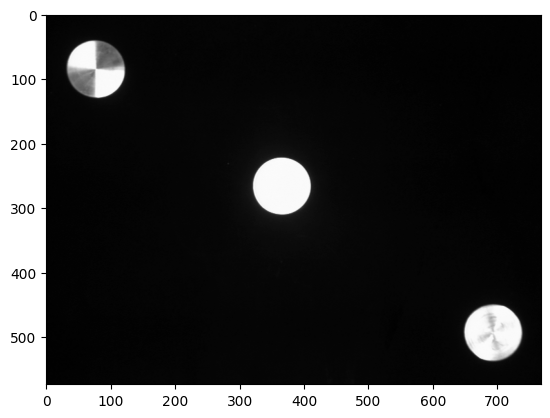

In [ ]:
plt.imshow(image4, cmap='gray')
plt.show()

Calibration effectuée : 1 pixel = 0.4787 mm


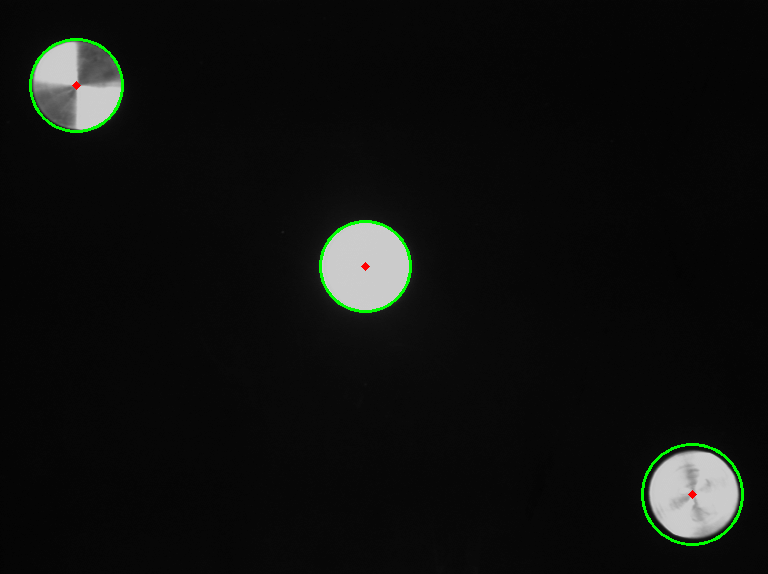

In [ ]:
def calibrate_image(image_path, real_diameter_mm=45.0):
    """Calibre l'image en utilisant une pièce étalon de 45 mm."""

    # Charger l’image en niveaux de gris
    image4 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image4 is None:
        print("Erreur : Impossible de charger l'image.")
        return None

    # Appliquer un flou gaussien plus intense pour réduire le bruit
    blurred = cv2.GaussianBlur(image4, (9, 9), 2)

    # Appliquer un seuillage adaptatif pour améliorer le contraste
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 15, 4)

    # Détection des cercles avec la transformée de Hough
    circles = cv2.HoughCircles(thresholded, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=80, param2=30, minRadius=20, maxRadius=60)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        diameters_px = []

        # Convertir l'image en couleur pour afficher les cercles
        image_color = cv2.cvtColor(image4, cv2.COLOR_GRAY2BGR)

        for circle in circles[0, :]:
            x, y, radius = circle
            diameter = 2 * radius
            diameters_px.append(diameter)

            # Dessiner les cercles détectés
            cv2.circle(image_color, (x, y), radius, (0, 255, 0), 2)
            cv2.circle(image_color, (x, y), 2, (0, 0, 255), 3)  # Marquer le centre

        # Calculer la moyenne des diamètres détectés
        avg_diameter_px = np.mean(diameters_px)
        resolution_mm_px = real_diameter_mm / avg_diameter_px  # mm/px

        print(f"Calibration effectuée : 1 pixel = {resolution_mm_px:.4f} mm")

        # Afficher l’image avec les cercles détectés dans Colab
        cv2_imshow(image_color)

        return resolution_mm_px  # Retourne la résolution mm/px
    else:
        print("Aucune pièce détectée. Ajustez les paramètres de HoughCircles.")
        return None

# Exécuter la calibration
resolution_mm_px = calibrate_image(image_path)


L’image est convertie en niveaux de gris pour faciliter la détection des contours. Un flou gaussien est appliqué pour réduire le bruit et améliorer la détection des bords. Un seuillage adaptatif est utilisé pour maximiser le contraste entre la pièce et l’arrière-plan. La fonction cv2.HoughCircles est utilisée pour détecter automatiquement les cercles présents dans l’image. Plusieurs paramètres sont réglés (minRadius, maxRadius, param1, param2) pour optimiser la détection des bords. Une fois les cercles détectés, leurs diamètres en pixels sont mesurés. La moyenne des diamètres détectés est calculée pour plus de robustesse. La résolution est obtenue en divisant le diamètre réel par le diamètre détetecté.

La meilleure résolution que nous avons obtenu est 1 pixel = 0.4787 mm. Toutefois, nous pensons que pour en obtenir une meilleure, il aurait fallu ajuster les paramètres pour affiner la détection encore plus.

L’utilisation d’une pièce circulaire simplifie l’étalonnage car les cercles peuvent être détectés avec précision via des méthodes robustes comme la transformée de Hough. Contrairement à des formes irrégulières, un cercle permet une mesure cohérente du diamètre indépendamment de l’orientation de la pièce, garantissant une calibration fiable de la résolution en mm/pixel. De plus, les cercles sont insensibles aux variations d’angle de prise de vue, réduisant ainsi les erreurs de perspective.

Placer la pièce de calibration à plusieurs endroits permet de tester l’homogénéité de la résolution sur l’ensemble du champ de vision. Cela permet d’identifier d’éventuelles distorsions optiques de la caméra, comme des aberrations radiales qui pourraient fausser les mesures en périphérie de l’image. Cette approche garantit que la calibration est valide sur toute la zone d’acquisition et pas seulement en un point précis.

Une pièce de faible épaisseur minimise les effets de parallaxe et d’ombres portées, garantissant une détection plus précise des contours. Une pièce trop épaisse pourrait générer des erreurs de mesure si la lumière crée des ombres sur les bords, faussant la perception du diamètre. De plus, une fine épaisseur assure que la mise au point de la caméra reste nette, facilitant ainsi une segmentation plus efficace de la pièce étalon.

### 2. Choix d’une méthode de contrôle automatique

Largeur de serrage détectée : 46 pixels


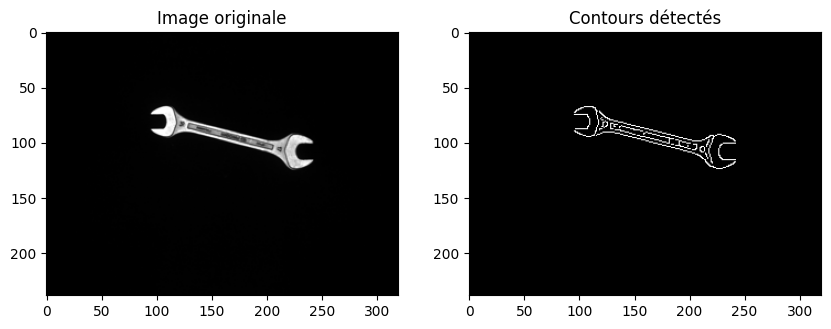

In [ ]:
def measure_key_width(image_path):
    """Mesure la largeur de serrage de la clé en détectant ses contours."""

    # Charger l’image en niveaux de gris
    if image is None:
        print("Erreur : Impossible de charger l'image.")
        return None

    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Détection des contours avec Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Déterminer la région d’intérêt (ROI) où se trouve la clé
    height, width = edges.shape
    roi = edges[int(height * 0.4):int(height * 0.7), :]  # Zone centrale

    # Profils de lignes : Somme des pixels blancs par colonne
    vertical_profile = np.sum(roi, axis=0)

    # Détection des pics (bords gauche et droit)
    threshold = np.max(vertical_profile) * 0.5  # Seuil adaptatif
    edges_x = np.where(vertical_profile > threshold)[0]

    if len(edges_x) >= 2:
        # Mesure la largeur entre le premier et le dernier bord détecté
        key_width_px = edges_x[-1] - edges_x[0]
        print(f"Largeur de serrage détectée : {key_width_px} pixels")
    else:
        print("Impossible de détecter les bords du serrage.")

    # Affichage des résultats
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Image originale")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Contours détectés")

    plt.show()

    return key_width_px if len(edges_x) >= 2 else None

# Exécuter la mesure
key_width_px = measure_key_width(image_path)

L’image est d'abord chargée en niveaux de gris. Pour améliorer la précision de la détection, un flou gaussien est appliqué. Ce filtrage permet de réduire le bruit et les détails inutiles qui pourraient perturber la détection des contours. La détection des contours est effectuée avec l’algorithme de Canny. Cette technique met en évidence les bords de la clé en détectant les transitions abruptes d’intensité dans l’image. Nous avons également essayé de sélectionner une ROI pour se concentrer sur la zone utile et réduire l'impact du bruit. Toutefois, nous n'avons pas réussi à le faire de façon optimale, il aurait fallu réduire encore cette zone pour des mesures plus précises. Un profil vertical est calculé en sommant les pixels blancs (correspondant aux contours) de chaque colonne dans la ROI. Ce profil permet de repérer les positions où les contours sont les plus marqués, correspondant aux bords gauche et droit de la clé.
Pour déterminer la largeur de serrage, un seuil adaptatif est défini afin de détecter les pics les plus significatifs du profil vertical. Les indices des colonnes où l'intensité dépasse ce seuil sont extraits. Si au moins deux bords sont détectés, la largeur de serrage est calculée comme la distance entre le premier et le dernier bord détecté.

L’algorithme a détecté une largeur de serrage de 46 pixels. L’image des contours détectés montre que les bords de la clé sont bien identifiés, confirmant la pertinence de la méthode. Toutefois, des ajustements de paramètres (seuil de Canny, ROI plus précise) pourraient être nécessaires pour garantir la robustesse de la mesure sur différentes images.

Cette méthode est efficace, mais peut être sensibles aux variations d'éclairage et de contraste. Pour l’améliorer, on pourrait affiner la sélection de la ROI ou utiliser une approche basée sur la transformée de Hough pour détecter directement les arêtes de la clé.

La détection des contours repose sur l’algorithme de Canny, qui est très sensible aux variations de luminosité et de contraste. Si l’éclairage est inhomogène ou insuffisant, certains contours peuvent être mal détectés, ce qui fausse la mesure de la largeur de serrage. Même avec un filtrage gaussien, des bruits ou reflets parasites peuvent être présents dans l’image. Ces éléments peuvent générer des faux contours qui perturbent l’analyse du profil vertical et entraînent une mesure erronée. Le seuil utilisé pour extraire les bords de la clé est adaptatif, mais peut ne pas être optimal pour toutes les images. Dans certains cas, un seuil trop bas pourrait inclure du bruit, tandis qu’un seuil trop élevé risquerait d’exclure certaines parties des contours. Si la clé est légèrement inclinée dans l’image, la méthode actuelle, qui projette les bords sur un profil vertical, peut surestimer ou sous-estimer la largeur réelle de serrage. Une solution serait d’aligner l’orientation de la clé avant de mesurer sa largeur.

Largeur de serrage détectée : 15 pixels


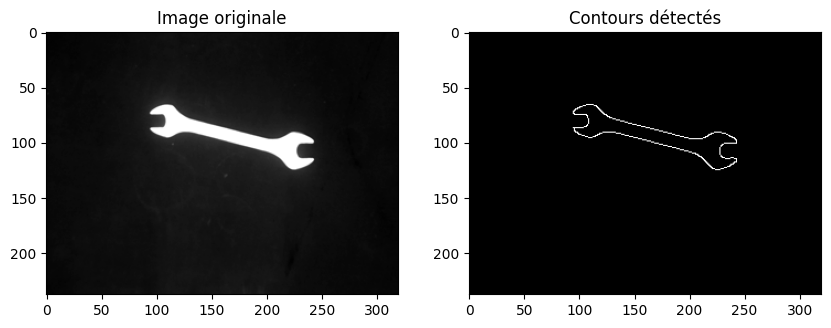

In [ ]:
def measure_key_width(image_path):
    """Mesure la largeur de serrage de la clé en détectant ses contours."""

    # Charger l’image en niveaux de gris
    if image2 is None:
        print("Erreur : Impossible de charger l'image.")
        return None

    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(image2, (5, 5), 0)

    # Détection des contours avec Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Déterminer la région d’intérêt (ROI) où se trouve la clé
    height, width = edges.shape
    roi = edges[int(height * 0.4):int(height * 0.6), :]  # Zone centrale

    # Profils de lignes : Somme des pixels blancs par colonne
    vertical_profile = np.sum(roi, axis=0)

    # Détection des pics (bords gauche et droit)
    threshold = np.max(vertical_profile) * 0.5  # Seuil adaptatif
    edges_x = np.where(vertical_profile > threshold)[0]

    if len(edges_x) >= 2:
        # Mesure la largeur entre le premier et le dernier bord détecté
        key_width_px = edges_x[-1] - edges_x[0]
        print(f"Largeur de serrage détectée : {key_width_px} pixels")
    else:
        print("Impossible de détecter les bords du serrage.")

    # Affichage des résultats
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image2, cmap="gray")
    plt.title("Image originale")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Contours détectés")

    plt.show()

    return key_width_px if len(edges_x) >= 2 else None

# Exécuter la mesure
key_width_px = measure_key_width(image_path)

Largeur de serrage détectée : 59 pixels


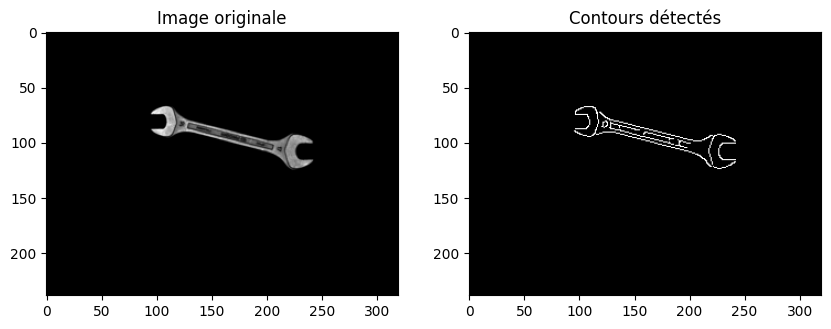

In [ ]:
def measure_key_width(image_path):
    """Mesure la largeur de serrage de la clé en détectant ses contours."""

    # Charger l’image en niveaux de gris
    if image3 is None:
        print("Erreur : Impossible de charger l'image.")
        return None

    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(image3, (5, 5), 0)

    # Détection des contours avec Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Déterminer la région d’intérêt (ROI) où se trouve la clé
    height, width = edges.shape
    roi = edges[int(height * 0.4):int(height * 0.6), :]  # Zone centrale

    # Profils de lignes : Somme des pixels blancs par colonne
    vertical_profile = np.sum(roi, axis=0)

    # Détection des pics (bords gauche et droit)
    threshold = np.max(vertical_profile) * 0.5  # Seuil adaptatif
    edges_x = np.where(vertical_profile > threshold)[0]

    if len(edges_x) >= 2:
        # Mesure la largeur entre le premier et le dernier bord détecté
        key_width_px = edges_x[-1] - edges_x[0]
        print(f"Largeur de serrage détectée : {key_width_px} pixels")
    else:
        print("Impossible de détecter les bords du serrage.")

    # Affichage des résultats
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image3, cmap="gray")
    plt.title("Image originale")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Contours détectés")

    plt.show()

    return key_width_px if len(edges_x) >= 2 else None

# Exécuter la mesure
key_width_px = measure_key_width(image_path)

## Partie 2 : Segmentation des cellules basophiles

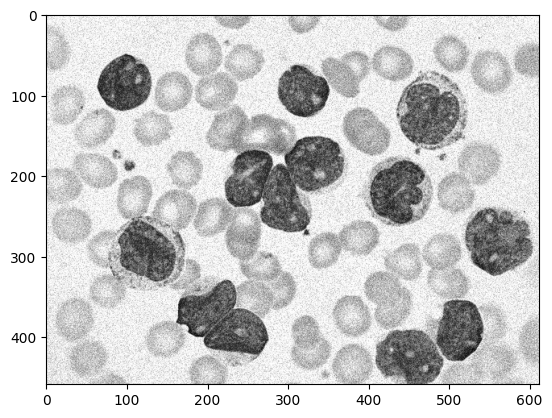

In [ ]:
image_path = "/content/imageonline-co-noisedimage.png"
image5 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image5, cmap='gray')
plt.show()

L’image bruitée est chargée en niveaux de gris à l’aide d’OpenCV, puis affichée avec Matplotlib. Cela permet de visualiser l’image initiale avant tout traitement et d’évaluer l’impact du bruit sur la qualité visuelle. L'objectif est de trouver une méthode pour compter automatiquement les cellules basophiles dans l’image.

### 1. Segmentation avec Seuillage d’Otsu

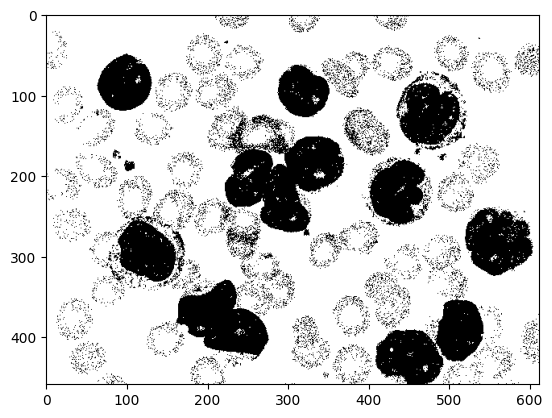

In [ ]:
def otsu_threshold(image5):
    hist = compute_histogram(image5)  # Calcul de l'histogramme
    total_pixels = image5.size
    probas = hist / total_pixels  # Probabilité d'apparition pour chaque pixel
    global_mean = np.mean(image5)  # Moyenne globale

    # Initialisation
    best_threshold = 0
    max_between_class_variance = 0
    w0, w1, mean0, mean1 = 0, 0, 0, 0

    for t in range(256):
        w0 += probas[t]
        if w0 == 0 or w0 == 1:
            continue
        w1 = 1 - w0
        mean0 += t * probas[t]
        mean1 = (global_mean - mean0) / w1

        between_class_variance = w0 * w1 * (mean0 / w0 - mean1) ** 2

        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            best_threshold = t

    binary_image = np.where(image5 > best_threshold, 255, 0).astype(np.uint8)

    return best_threshold, binary_image

best_threshold, image_otsu = otsu_threshold(image5)
plt.imshow(image_otsu, cmap="gray")
plt.show()

Le seuillage d'Otsu permet de séparer les cellules du fond en identifiant un seuil optimal basé sur la distribution des niveaux de gris. On veut pouvoir distinguer les cellules basophiles (en noir) des autres cellules du corps humains (en blanc).

### 2. Détection des Contours

Nombre de cellules basophiles détectées : 1


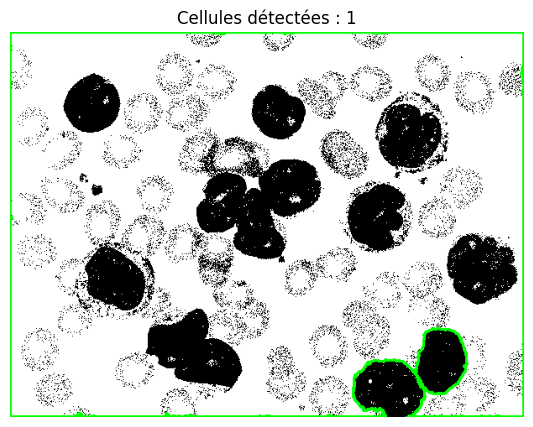

In [ ]:
contours, _ = cv2.findContours(image_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cell_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

output_image = cv2.cvtColor(image_otsu, cv2.COLOR_GRAY2BGR)
cv2.drawContours(output_image, cell_contours, -1, (0, 255, 0), 2)

num_cells = len(cell_contours)
print(f"Nombre de cellules basophiles détectées : {num_cells}")

plt.figure(figsize=(10, 5))
plt.imshow(output_image, cmap='gray')
plt.title(f"Cellules détectées : {num_cells}")
plt.axis("off")
plt.show()

On identifie les contours des cellules en éliminant les bruits parasites pour mieux isoler les cellules basophiles. Comme on peut le voir, elle n'en détecte qu'une ou deux. La méthode employée n'est donc pas assez robuste.

### 3. Application de Filtres Passe-Haut pour Détection de Bords

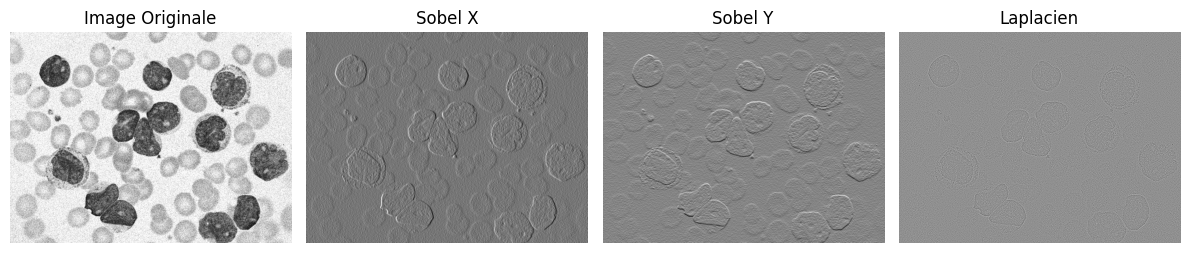

In [ ]:
kernels = {
    "Sobel X": np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    "Sobel Y": np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    "Laplacien": np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]),
}

filtered_images = {name: convolve2d(image5, kernel, mode='same', boundary='symm') for name, kernel in kernels.items()}

plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(image5, cmap='gray')
plt.title("Image Originale")
plt.axis("off")

for i, (name, img) in enumerate(filtered_images.items(), 2):
    plt.subplot(1, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()


Trois filtres (Sobel X, Sobel Y et Laplacien) sont appliqués pour détecter les contours de l’image. Ces filtres accentuent les bords et améliorent la séparation entre les cellules et l’arrière-plan, permettant de mieux définir les contours des cellules.

On peut voir que les filtres ne sont pas très performant pour cette image (surtout Laplacien).

### 4. Détection des Cellules Basophiles avec l’Espace Couleur HSV

In [ ]:
hsv = cv2.cvtColor(image5, cv2.COLOR_BGR2HSV)
lower_violet = np.array([120, 80, 50])
upper_violet = np.array([160, 255, 255])

mask = cv2.inRange(hsv, lower_violet, upper_violet)
kernel = np.ones((5,5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

output_image = image5.copy()
cv2.drawContours(output_image, filtered_contours, -1, (0, 255, 0), 2)

num_cells = len(filtered_contours)
print(f"Nombre de cellules violettes détectées : {num_cells}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image5, cv2.COLOR_BGR2RGB))
plt.title("Image originale")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_cleaned, cmap='gray')
plt.title("Masque de détection (violet)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f"Détection des cellules ({num_cells} trouvées)")
plt.axis("off")
plt.show()


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Notre code ne fonctionne pas ici mais nous n'arrivons pas à réparer l'erreur. Puisque nous avons travaillé en binôme, nous avons réussi à l'exécuter sur l'autre notebook sur lequel nous travaillions simultanément. Voici les captures d'écrans des résultats.

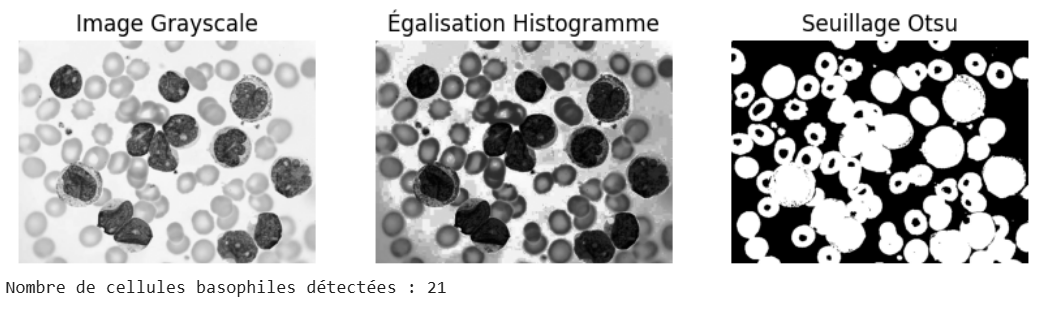

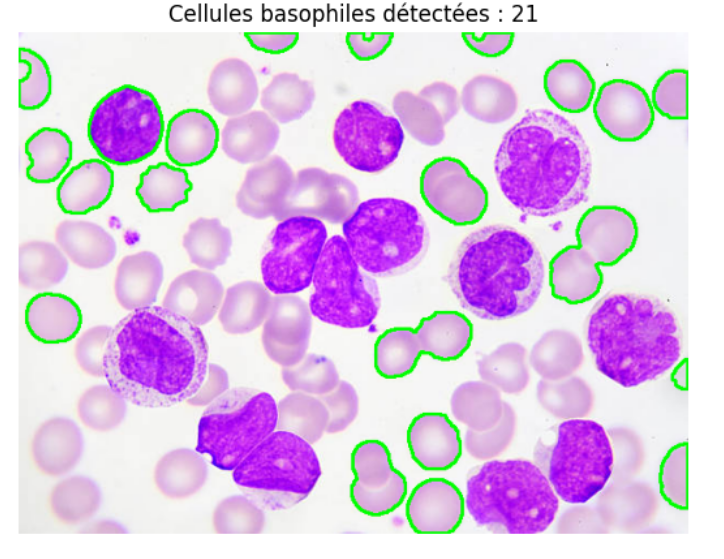

L’image est d’abord convertie en niveaux de gris, puis son histogramme est égalisé pour améliorer le contraste. Ensuite, un seuillage d’Otsu est appliqué pour obtenir une segmentation plus précise. Une opération morphologique d’ouverture est réalisée pour éliminer les petits artefacts, et les contours des cellules sont extraits en filtrant selon la taille et la circularité. Cela permet d’optimiser la détection des cellules basophiles.

Les contours des objets sont extraits de l’image binaire en utilisant la fonction cv2.findContours(). Un filtrage basé sur l’aire des contours est appliqué pour éliminer les faux positifs liés au bruit. Les contours valides sont ensuite dessinés sur l’image originale, permettant ainsi de visualiser les structures détectées et de compter le nombre d’objets identifiés. Il y a encore des erreurs au niveau de la détection des cellules basophiles, nous allons donc essayer une autre méthode.



In [ ]:
# Vérifier si l'image est chargée
if image is None:
    print("Erreur : Impossible de charger l'image.")
    exit()

# Convertir en espace HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Définir les seuils pour détecter les cellules violettes (et éviter le rose)
lower_violet = np.array([120, 80, 50])  # Ajustement des valeurs min
upper_violet = np.array([160, 255, 255])  # Ajustement des valeurs max

# Créer un masque pour extraire uniquement les zones violettes
mask = cv2.inRange(hsv, lower_violet, upper_violet)

# Appliquer une ouverture pour enlever le bruit
kernel = np.ones((5,5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Appliquer une fermeture pour combler les trous dans les cellules
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

# Détection des contours des cellules violettes
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrer les petits contours (bruit) en fixant un seuil minimal d'aire
min_area = 500  # Ajuster selon la taille des cellules
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Dessiner uniquement les contours détectés sur l'image originale
output_image = image.copy()
cv2.drawContours(output_image, filtered_contours, -1, (0, 255, 0), 2)

# Nombre de cellules détectées
num_cells = len(filtered_contours)
print(f"Nombre de cellules violettes détectées : {num_cells}")

# Afficher les résultats
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image originale")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_cleaned, cmap='gray')
plt.title("Masque de détection (violet)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f"Détection des cellules ({num_cells} trouvées)")
plt.axis("off")

plt.show()

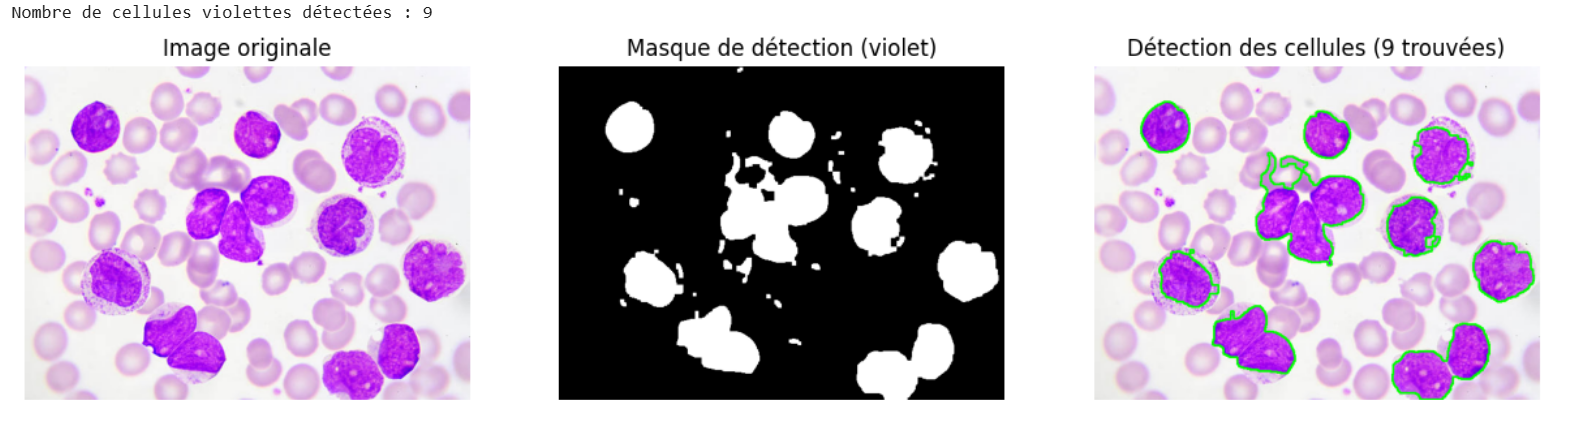

L’image est convertie en espace de couleur HSV afin d’isoler les cellules violettes, distinctes du fond et des autres structures. Un masque de détection est appliqué avec des seuils définis pour capturer ces cellules. Des opérations morphologiques d’ouverture et de fermeture sont effectuées pour réduire le bruit et combler les petits trous. Les contours des cellules violettes sont ensuite extraits et affichés sur l’image originale.

La détection des cellules basophiles est presque réussie puisque l'algorithme est capable de détecter 9 cellules sur 13 cellules basophiles.